# Asymptotic Homogenisation

This notebook uses asymptotic homohenisation to homogenise the heat equation over a **periodic** domain.

## The problem

We seek a homogenised model of the heat equation with spatially varying, but periodic heat conduction $\lambda(y)$ with $y$ being a periodic spatial coordinate $y\mapsto x/\epsilon$.

$$
-\nabla\cdot(\lambda\nabla u) = 0
$$

with $\lambda(x)$ having period $\epsilon$. 

## Homogenised equation

Through asymptotic homogenisation, the solution can be constructed in a power series in $\epsilon$

$$
u_\epsilon(x,y) = \sum_{i=0}^\infty \epsilon^i u_i(x,y)
$$

Inserting into the heat equation and through manupulation of the set of equations generated through grouping acording to powers of $\epsilon$, the following homogenised model can be constructed:

$$
-\nabla\cdot {\bf A}\nabla u_0(x) = 0\\
A_{ij} = \int_Y \lambda(y)\cdot(e_j + \nabla_y w_j)\cdot(e_i + \nabla_y w_i)\,dy\\
-\nabla_y\cdot \lambda(y)(e_i+ \nabla_y w_i) = 0\quad y\mapsto w(y)\\
$$

# Solution using FEM

In [372]:
from dolfin import *;
import matplotlib.pyplot as plt;
import numpy as np;

## Numerical parameter
nx = 100      # Grid-size horizontal
ny = 100     # Grid-size vertical

## Problem parameter
alpha = 0.01
radius = 0.75

## Definition of domain and mesh

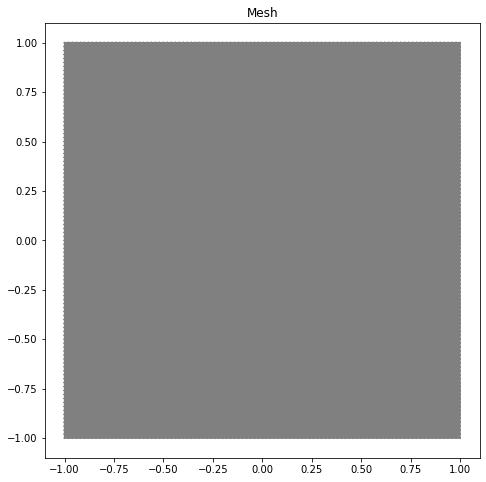

In [373]:
mesh = RectangleMesh(Point(-1.0,-1.0),Point(1.,1.),nx,ny,"crossed");
V = FunctionSpace(mesh, "Lagrange", 2);

plt.figure(figsize=(8,8));
plot(mesh, title="Mesh");

## Subdomains

We will define subdomains for the regions with different heat conductivity

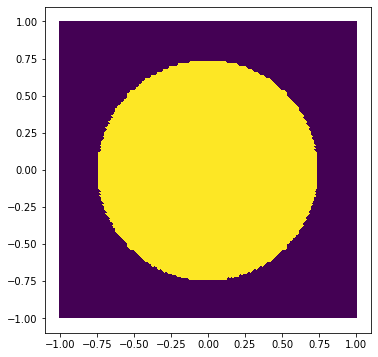

In [374]:
class OmegaA(SubDomain):
    
    r = 1.0;
    
    def __init__(self,r):
        super(OmegaA, self).__init__()
        self.r = r;
        
    def inside(self, x, on_boundary):
        return (x[0]*x[0] + x[1]*x[1]) < self.r**2;

# Sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], -1.) or near(x[1], -1.)) and 
                (not ((near(x[0], -1.) and near(x[1], 1.)) or 
                        (near(x[0], 1.) and near(x[1], -1.)))) and on_boundary)

    def map(self, x, y):
        if near(x[0], 1.) and near(x[1], 1.):
            y[0] = x[0] - 2.
            y[1] = x[1] - 2.
        elif near(x[0], 1.):
            y[0] = x[0] - 2.
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - 2.

        
# Create periodic boundary condition
pbc = PeriodicBoundary()
# Initialize sub-domain instances
omegaA = OmegaA(radius)

# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
omegaA.mark(domains, 1)

plt.figure(figsize=(10,6));
plot(domains);

## Variational Form

$$
-\int_\Omega \nabla_y\cdot \lambda(y)(e_i + \nabla_y w_i)\cdot v\,dy = 0\\
-\int_{\partial\Omega}\lambda(y)(e_i + \nabla_y w_i)\cdot n\cdot v\,ds + \int_\Omega \lambda(y)(e_i + \nabla_y w_i)\cdot \nabla_y v\,dy = 0\\
-\int_{\partial\Omega}\lambda(y)(\nabla_y w_i\cdot n)\cdot v\,ds + \int_\Omega \lambda(y)( \nabla_y w_i\cdot \nabla_y v)\,dy = \int_{\partial\Omega}\lambda(y)(e_i\cdot n)\cdot v\,ds -\int_\Omega \lambda(y)(e\cdot\nabla_y v)\,dy
$$

In [375]:
def solution(e,alpha):
    '''
    Compute solution of the auxilary problem for a given drift vector e
    
    Returns the solved field w(y)
    '''
    
    V = FunctionSpace(mesh, "CG", 1, constrained_domain=pbc)

    # Define variational problem
    w = TrialFunction(V)
    v = TestFunction(V)

    # Define new measures associated with the interior domains
    dy = Measure('dx', domain=mesh, subdomain_data=domains)
    
    e = Constant(e)
    alpha = Constant(alpha)

    # Create facet normals for boundary integrals. 
    # Note: taking the outward facing facets creates a solution that breaks symmetry
    #       Not sure what is correct, for now we go with the high symmetry solution
    #       and flip the normals
    n = -FacetNormal(mesh)

    a1 = -inner(grad(w),n)*v*ds
    a2 =  dot(grad(w), grad(v))*dy(0)
    a3 =  alpha*dot(grad(w), grad(v))*dy(1)
    a  =  a1+a2+a3

    l1 =  inner(e,n)*v*ds
    l2 = -dot(e,grad(v))*dy(0)
    l3 = -alpha*dot(e,grad(v))*dy(1)
    L  =  l1+l2+l3
    
    u = Function(V)
    solve(a == L, u);
    
    return u

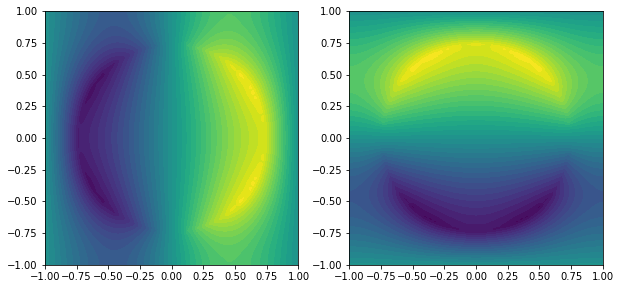

In [376]:
w = [None,None]
w[0] = solution((1.,0),alpha)
w[1] = solution((0,1.),alpha)


fig=plt.figure(figsize=(10, 8));
fig.add_subplot(1, 2, 1);
plot(w[0])
fig.add_subplot(1, 2, 2);
plot(w[1])

## Effective Transport Coefficients

The transport coefficient matrix can be computed from:
$$
A_{ij} = \int_Y \lambda(y)\cdot(e_j + \nabla_y w_j)\cdot(e_i + \nabla_y w_i)\,dy\\
$$

In [379]:
def effective_coeff(w,domains,alpha):
    '''
    Compute effective transport matrix for solution w
    '''
    
    A = np.zeros((2,2))
    
    e = [None,None]
    e[0] = Constant((1.,0))
    e[1] = Constant((0,1.))
    
    dx = Measure('dx', domain=mesh, subdomain_data=domains)
    total = assemble(Constant(1.0)*dx)
    
    for i in range(2):
        for j in range(2):
            gj = grad(w[j])
            gi = grad(w[i])
            ej = e[j]
            ei = e[i]
            A[i,j] = assemble(
                      dot(ej+gj,ei+gi)*dx(0)
                    + alpha*dot(ej+gj,ei+gi)*dx(1)
            ) / total;
            
    return A

def phase_fraction(domains):
    '''
    Computes the phase fraction of the problem
    '''
    
    dx = Measure('dx', domain=mesh, subdomain_data=domains)
    
    total = assemble(Constant(1.0)*dx)
    phase = assemble(Constant(1.0)*dx(1))
    
    return phase/total
    

In [380]:
print("Phase fraction: {}".format(phase_fraction(domains)))
effective_coeff(w,domains,alpha)

Phase fraction: 0.432599999999522


array([[3.99303056e-01, 7.47559309e-19],
       [7.47559309e-19, 3.99303056e-01]])